In [144]:
#import of important libraries
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Importing the data

In [0]:
#import train and test data sets
train_df = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [146]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [147]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## 2. EDA

Let's get some informations about the datasets

In [148]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [149]:
#Missing values in training set
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [150]:
#Missing values in test set
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

A lot of values are missing in both train and test set but it won't affect us as we are mainly going to work with the "text" column

### Exploring the target column



Let's see the distribution of the target column



In [151]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

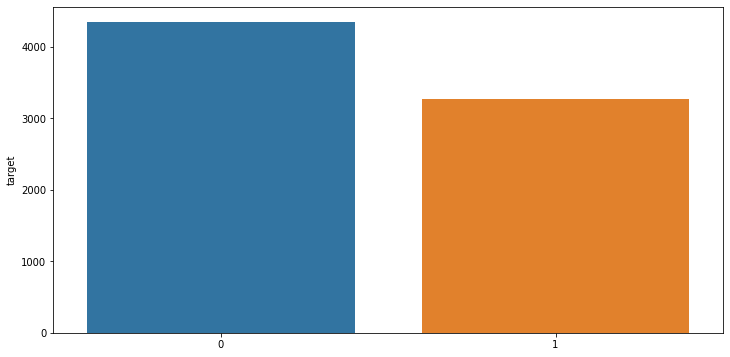

In [152]:
#let's visualize the distribution of target value 
sns.barplot(train_df['target'].value_counts().index,train_df['target'].value_counts())



*   Exploring the Target Column :  Let's look at what the disaster and the non disaster tweets look like



In [153]:
# A disaster tweet
disaster_tweets = train_df[train_df['target']==1]['text']
disaster_tweets.values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [154]:
#not a disaster tweet
non_disaster_tweets = train_df[train_df['target']==0]['text']
non_disaster_tweets.values[0]

"What's up man?"


### Exploring the 'keyword' column

The keyword column contains a keyword from the tweet. Let's look at the top keywords in the training data


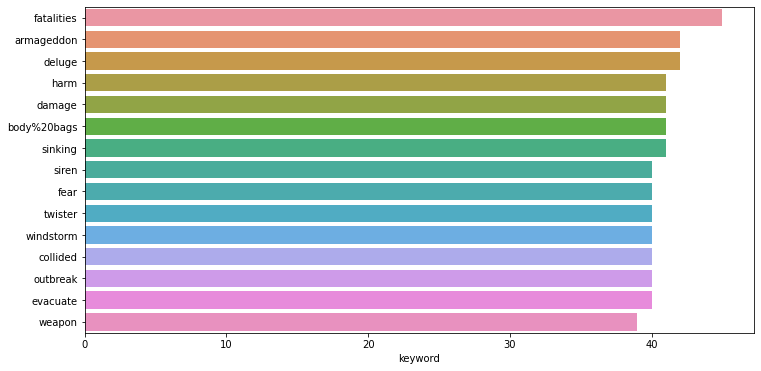

In [155]:
sns.barplot(y=train_df['keyword'].value_counts()[:15].index,x=train_df['keyword'].value_counts()[:15],
            orient='h')

### Common stopwords and punctuation

Let's look at the common stopwords and punctuation for disaster and non-disaster tweets.

In [0]:
stopw = set(stopwords.words('english'))

we need to create a corpus for disaster and non-disaster tweets.

In [0]:
#target will be either 1 ou 0
def create_corpus(target):
    corpus=[]
    
    for x in train_df[train_df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

In [0]:
disaster_corpus = create_corpus(1)
non_disaster_corpus = create_corpus(0)

In [0]:
from collections import defaultdict, Counter
import warnings
import re
import random 

dic_disaster=defaultdict(int)
for word in disaster_corpus:
    if word in stopw:
        dic_disaster[word]+=1
        
dic_non_disaster=defaultdict(int)
for word in non_disaster_corpus:
    if word in stopw:
        dic_non_disaster[word]+=1 

In [0]:
top_disaster = sorted(dic_disaster.items(), key=lambda x:x[1],reverse=True)[:10] 
top_non_disaster = sorted(dic_non_disaster.items(), key=lambda x:x[1],reverse=True)[:10] 

In [0]:
x1,y1=zip(*top_disaster)
x2,y2=zip(*top_non_disaster)
top_stop = pd.DataFrame({'Target':[1]*10+[0]*10, 'Word': [x for x in x1]+[x for x in x2], 'Occurances': [y for y in y1]+[y for y in y2] })

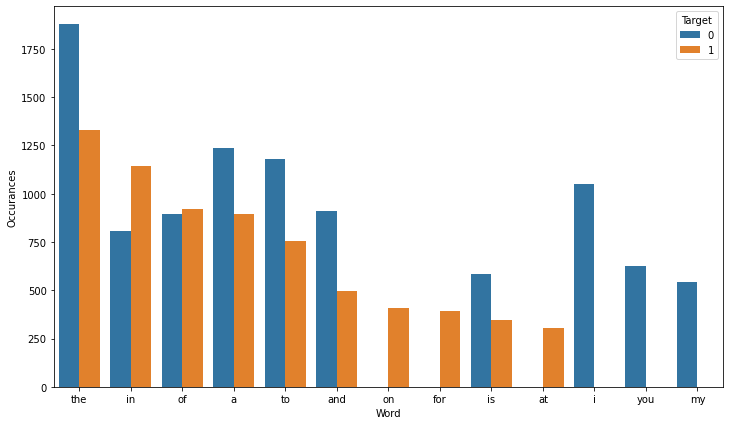

In [162]:
plt.figure(figsize=(12,7))
sns.barplot(x='Word',y='Occurances',data = top_stop,hue='Target')

We can see on the plot above the most common words and their occurances.We will have to do some cleaning here.

Now, let's see about the punctuation.



In [163]:
import string
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
dic_disaster_punct=defaultdict(int)
for word in disaster_corpus:
    if word in punctuation:
        dic_disaster_punct[word]+=1
        
dic_non_disaster_punct=defaultdict(int)
for word in non_disaster_corpus:
    if word in punctuation:
        dic_non_disaster_punct[word]+=1 

In [0]:
top_disaster_punct = sorted(dic_disaster_punct.items(), key=lambda x:x[1],reverse=True)[:10] 
top_non_disaster_punct = sorted(dic_non_disaster_punct.items(), key=lambda x:x[1],reverse=True)[:10]

In [0]:
x1,y1=zip(*top_disaster_punct)
x2,y2=zip(*top_non_disaster_punct)
top_punct = pd.DataFrame({'Target':[1]*10+[0]*10, 'Word': [x for x in x1]+[x for x in x2], 'Occurances': [y for y in y1]+[y for y in y2] })

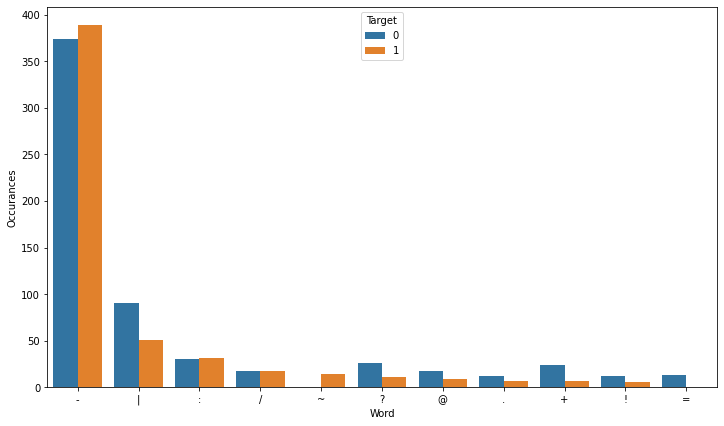

In [167]:
plt.figure(figsize=(12,7))
sns.barplot(x='Word',y='Occurances',data = top_punct,hue='Target')

We can see on the plot above the punctuation and their occurances.We need to do some cleaning here too.

### Common Words

we can now explore the most common words for each class.

In [0]:
counter_d = Counter(disaster_corpus)
most_disaster_words = counter_d.most_common()
x1=[]
y1=[]
for word,count in most_disaster_words[:50]:
    if (word not in stopw) :
        x1.append(word)
        y1.append(count)
        
counter_nd = Counter(non_disaster_corpus)
most_non_disaster_words = counter_nd.most_common()
x2=[]
y2=[]
for word,count in most_non_disaster_words[:50]:
    if (word not in stopw) :
        x2.append(word)
        y2.append(count) 

Text(0.5, 1.0, 'Not disaster')

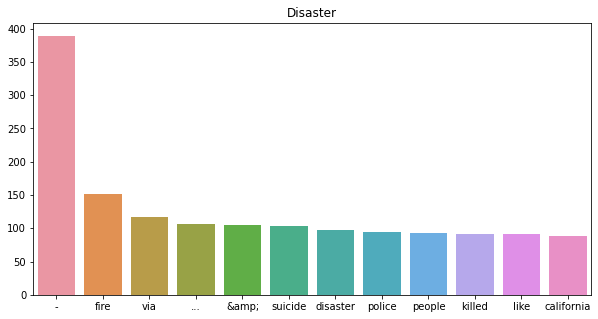

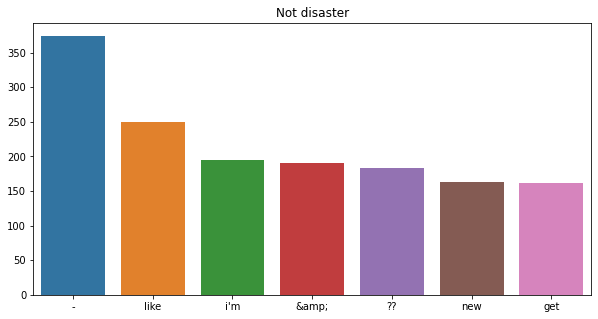

In [169]:
plt.figure(figsize=(10,5))
sns.barplot(x=x1,y=y1)
plt.title('Disaster')
plt.figure(figsize=(10,5))
sns.barplot(x=x2,y=y2)
plt.title('Not disaster')

We can see in plots above that there are some common words that are not actually words, that shows us the we need to remove them from our data.

### N-grams: bigrams and trigrams

n-grams are groups of consecutive characters in a word - i.e. 'mother' has bigrams mo, ot, th, he, er and trigrams mot, oth, the and her OR consecutive n-groups of words in a text - i.e. 'This is my text' would become 'this is', 'is my' and 'my text'. This is the traditional way of analysing text data and performing NLP

Let's start with Most common bigrams (n = 2)

In [0]:
def generate_ngrams(text, n):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stopw]
    ngrams = zip(*[token[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

In [0]:
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,2):
        disaster_bigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])

df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])        

In [172]:
df_disaster_bigrams.head()

,bigrams,frequency
0,suicide bomber,59
1,northern california,40
2,oil spill,37
3,california wildfire,31
4,bomber detonated,30


Let's visualize the bigrams 

Text(0.5, 1.0, 'Common bigrams - Not Disaster')

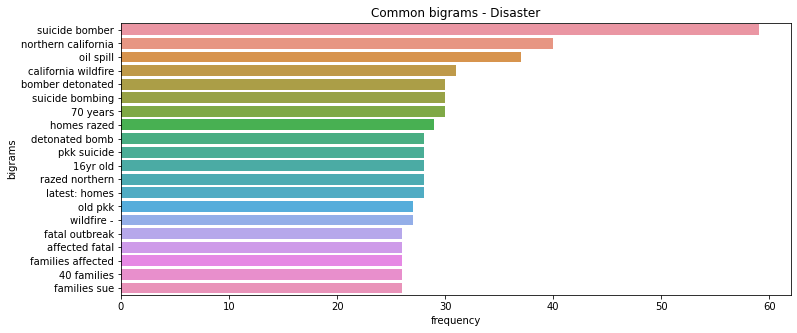

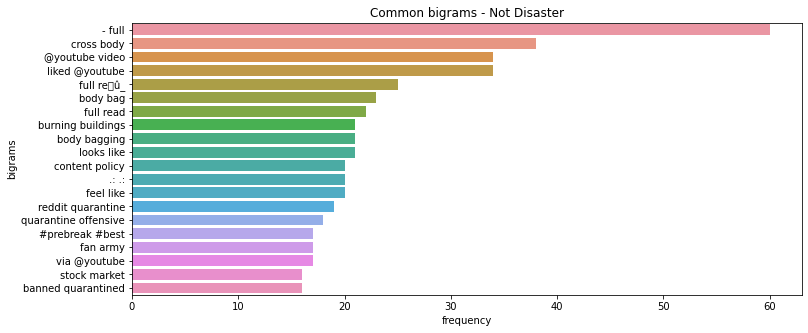

In [173]:
plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency', data=df_disaster_bigrams[:20])
plt.title('Common bigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency',data=df_nondisaster_bigrams[:20] )
plt.title('Common bigrams - Not Disaster')

Now the most common trigrams (n=3) and visualize them.

In [0]:
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,3):
        disaster_trigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])

df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])        

Text(0.5, 1.0, 'Common trigrams - Not Disaster')

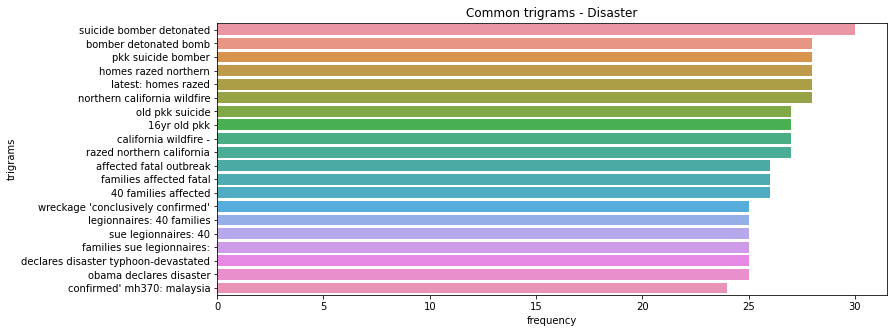

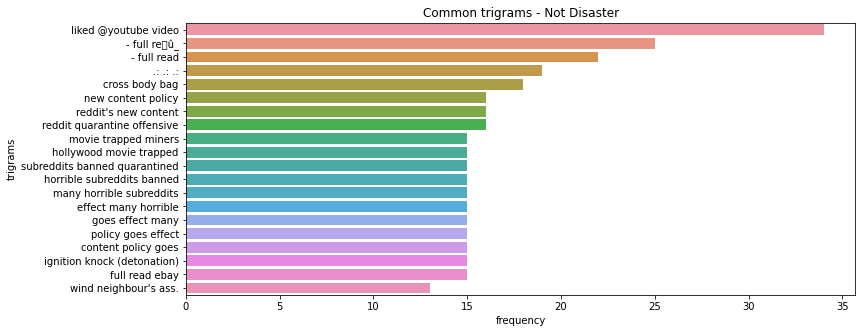

In [175]:
plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency', data=df_disaster_trigrams[:20])
plt.title('Common trigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency',data=df_nondisaster_trigrams[:20] )
plt.title('Common trigrams - Not Disaster')

It seems that the text is not clean and if we take a clearer look into the individual texts we notice that they contain URLs, weird abbreviations, emojis, @ and #'s, so the next task is to clean the text and then compute the n-grams again.

## 3. Cleaning data process

### 3.1 Removing URLs

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
#Let's use our remove_url function and apply it to our data
train_df['text'] = train_df['text'].apply(lambda x : remove_URL(x))

### 3.2 Removing HTMLs

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
#Let's use our remove_html function and apply it to our data
train_df['text'] = train_df["text"].apply(lambda x: remove_html(x))

### 3.3 Removing emojis

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
#Let's use our remove_emoji function and apply it to our data
train_df['text'] = train_df["text"].apply(lambda x: remove_emoji(x))

### 3.4 Removing punctuations

In [0]:
def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
#Let's use our remove_punctuation function and apply it to our data
train_df['text'] = train_df["text"].apply(lambda x: remove_punctuation(x))

### 3.5 Further cleaning

In [0]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [0]:
# Applying the clean_text function to our dataset
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))

In [186]:
# A quick glance over the existing data
train_df['text'][:20]

0     our deeds are the reason of this earthquake ma...
1                 forest fire near la ronge sask canada
2     all residents asked to shelter in place are be...
3      people receive wildfires evacuation orders in...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update  california hwy  closed in bo...
6     flood disaster heavy rain causes flash floodin...
7     im on top of the hill and i can see a fire in ...
8     theres an emergency evacuation happening now i...
9      im afraid that the tornado is coming to our area
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah wait a...
12    raining flooding florida tampabay tampa  or  d...
13                flood in bago myanmar we arrived bago
14    damage to school bus on  in multi car crash br...
15                                         whats up man
16                                        i love fruits
17                                     summer is

### 3.6 Redo bigrams and trigrams

Now let's compute bigrams and trigrams again with cleaned data

Text(0.5, 1.0, 'Common bigrams - Not Disaster')

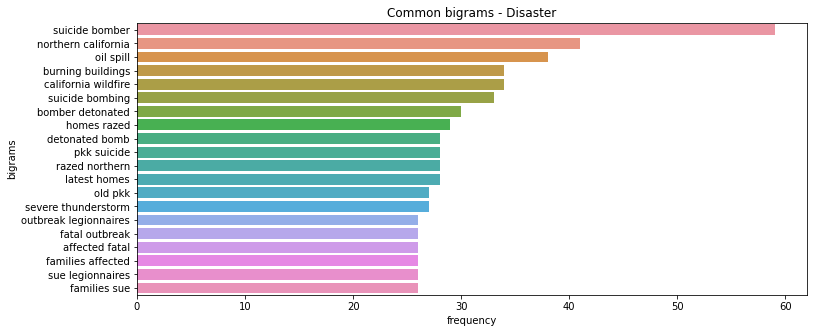

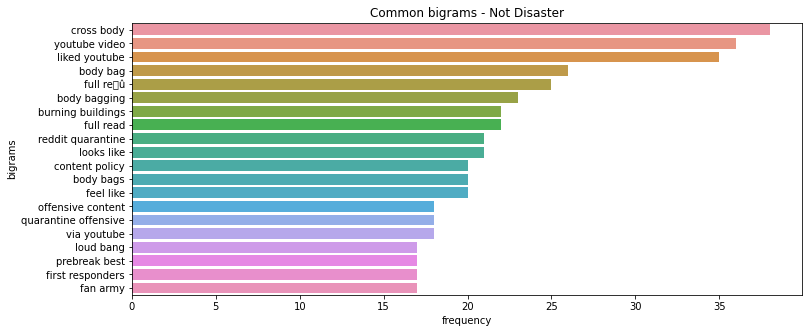

In [187]:
#bigrams (n=2)
cleaned_disaster_bigrams = defaultdict(int)
cleaned_nondisaster_bigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,2):
        cleaned_disaster_bigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,2):
        cleaned_nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(cleaned_disaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])

df_nondisaster_bigrams = pd.DataFrame(sorted(cleaned_nondisaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])    

plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency', data=df_disaster_bigrams[:20])
plt.title('Common bigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency',data=df_nondisaster_bigrams[:20] )
plt.title('Common bigrams - Not Disaster')

Text(0.5, 1.0, 'Common trigrams - Not Disaster')

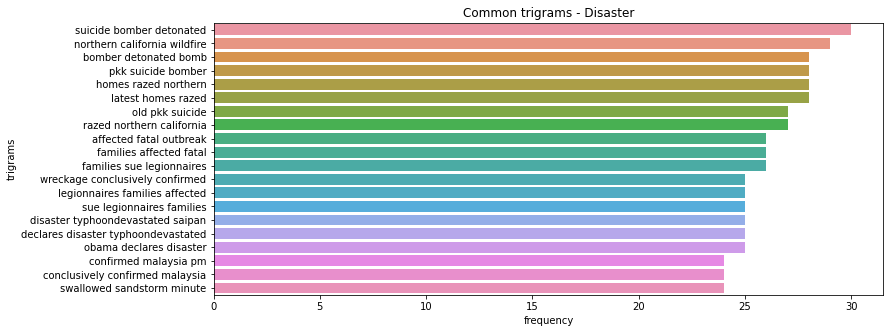

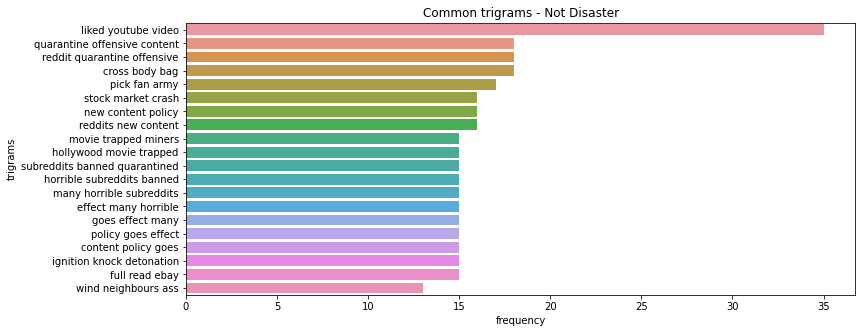

In [188]:
#trigrams (n=3)
cleaned_disaster_trigrams = defaultdict(int)
cleaned_nondisaster_trigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,3):
        cleaned_disaster_trigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,3):
        cleaned_nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(cleaned_disaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])

df_nondisaster_trigrams = pd.DataFrame(sorted(cleaned_nondisaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])    

plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency', data=df_disaster_trigrams[:20])
plt.title('Common trigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency',data=df_nondisaster_trigrams[:20] )
plt.title('Common trigrams - Not Disaster')

## 4. Building a model to predict disaster tweets



### 4.1 Bag of words + multinomialNB

A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

Now, as our first type of embedding we will use the vanilla bag of words - basically we will compute a matrix, in which the rows are the documents(tweets), and the columns are the words in our vocabulary, with the cell c(i,j) pointing to tweet i, word j and having a value of 1 if that word appears in that document, and 0 otherwise. For this, we will use CountVectorizer - however, we will use some specific parameters for it to make our life easier:

    

*   lowercase=True --> this will basically lowercase all words
*   stop_words = 'english' --> this will get rid of most common words in english ('the', 'are','I', 'a' etc.) as these would provide litte value in distinguishing wheter a tweet is referring to a disatser or not
* max_df = 0.95 --> this will only keep words that occur up to 95% of the documents, for a similar reason as above
* min_df = 2 --> this will only keep words which occur in at least 2 documents, as otherwise that specific word will be useless in our analysis



In [0]:
count_vectorizer = CountVectorizer(lowercase=True, stop_words='english', max_df=0.95, min_df=2)

In [0]:
X = count_vectorizer.fit_transform(list(train_df['text']))

In [191]:
#let's look at the vocabulary word_name :word_id
count_vectorizer.vocabulary_

{'deeds': 1336,
 'reason': 4236,
 'earthquake': 1604,
 'allah': 136,
 'forgive': 2041,
 'forest': 2037,
 'near': 3501,
 'la': 2885,
 'canada': 758,
 'residents': 4342,
 'asked': 281,
 'shelter': 4681,
 'place': 3904,
 'officers': 3639,
 'evacuation': 1757,
 'orders': 3701,
 'expected': 1799,
 'people': 3827,
 'receive': 4241,
 'wildfires': 5798,
 'california': 738,
 'just': 2798,
 'got': 2219,
 'sent': 4624,
 'photo': 3862,
 'alaska': 124,
 'smoke': 4812,
 'school': 4563,
 'rockyfire': 4438,
 'update': 5546,
 'hwy': 2533,
 'closed': 985,
 'lake': 2895,
 'county': 1165,
 'cafire': 728,
 'flood': 2001,
 'disaster': 1461,
 'heavy': 2397,
 'rain': 4173,
 'causes': 824,
 'flash': 1989,
 'flooding': 2003,
 'streets': 5011,
 'colorado': 1034,
 'springs': 4924,
 'areas': 241,
 'im': 2570,
 'hill': 2435,
 'woods': 5845,
 'theres': 5255,
 'emergency': 1670,
 'happening': 2337,
 'building': 686,
 'street': 5010,
 'afraid': 90,
 'tornado': 5354,
 'coming': 1044,
 'area': 240,
 'died': 1436,
 'heat

In [192]:
#now let's check which are our features and how many of them there are
print(count_vectorizer.get_feature_names())
len(count_vectorizer.get_feature_names())

['aa', 'aba', 'abandon', 'abandoned', 'abbott', 'abbswinston', 'abc', 'abcnews', 'abe', 'abia', 'ability', 'ablaze', 'able', 'abomb', 'abomination', 'abortion', 'absolute', 'absolutely', 'abstorm', 'abuse', 'abused', 'abuseddesolateamplost', 'abusing', 'ac', 'acc', 'accept', 'access', 'accident', 'accidentally', 'accidents', 'accionempresa', 'according', 'account', 'accounts', 'accused', 'accuses', 'accustomed', 'acdelco', 'achimota', 'acid', 'acoustic', 'acquire', 'acquisitions', 'acres', 'act', 'acted', 'acting', 'action', 'actions', 'activated', 'activates', 'active', 'activities', 'activity', 'actor', 'actress', 'acts', 'actual', 'actually', 'acute', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'address', 'admin', 'administration', 'admit', 'admits', 'adult', 'adults', 'advance', 'advanced', 'adventures', 'advertised', 'advice', 'advised', 'advisory', 'af', 'afc', 'affect', 'affected', 'affecting', 'affects', 'affiliation', 'afghan', 'afghanistan', 'afp', 'afraid', 'africa',

5982

In [0]:
X = X.toarray()

In [194]:
X.shape

(7613, 5982)

Now, we will split our training dataset into train and test, so that we can build our model on the training portion and test on the validation portion.

In [0]:
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)

Once we have split our data into train and test set, we will use a Naive Bayes classifier. Naive bayes is a good chocie for a medium-sized dataset and it is traditionally used in NLP.  We are going to use Multinomial NB as it is suitable for classification with discrete features. We will use GridSeachCV to look for optimal alpha for our model, and will use 5 folds for cross-validtion.

In [196]:
#list of alphas we are going to try
alpha_list = np.linspace(1, 100, 100)
alpha_list

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [0]:
parameter_grid = [{"alpha":alpha_list}]

In [198]:
clf= MultinomialNB()
gridsearch = GridSearchCV(clf,parameter_grid, scoring = 'neg_log_loss', cv = 5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

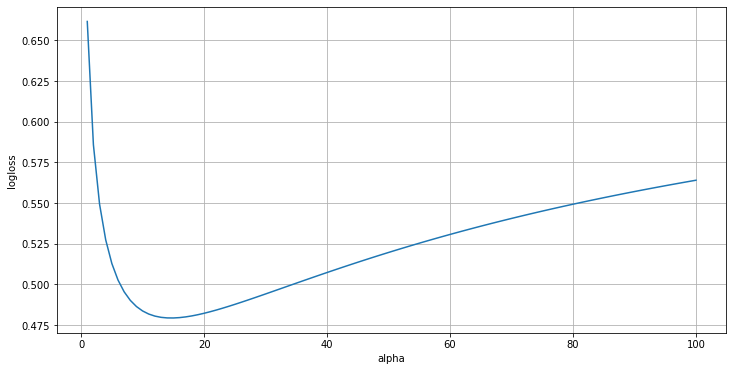

In [199]:
import matplotlib
results = pd.DataFrame()
# collect alpha list
results['alpha'] = gridsearch.cv_results_['param_alpha'].data
# collect test scores
results['neglogloss'] = gridsearch.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['alpha'], -results['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [200]:
print("Best parameter: ",gridsearch.best_params_)

Best parameter:  {'alpha': 15.0}


In [201]:
print("Best score: ",gridsearch.best_score_) 

Best score:  -0.47939031176439767


In [202]:
alpha_list2 = np.linspace(13, 18, 100)
parameter_grid2 = [{"alpha":alpha_list2}]
clf= MultinomialNB()
gridsearch2 = GridSearchCV(clf,parameter_grid2, scoring = 'neg_log_loss', cv = 5)
gridsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([13.        , 13.05050505, 13.1010101 , 13.15151515, 13.2020202 ,
       13.25252525, 13.3030303 , 13.35353535, 13.4040404 , 13.45454545,
       13.50505051, 13.55555556, 13.60606061, 13.65656566, 13.70707071,
       13.75757576, 13.80808081,...
       16.78787879, 16.83838384, 16.88888889, 16.93939394, 16.98989899,
       17.04040404, 17.09090909, 17.14141414, 17.19191919, 17.24242424,
       17.29292929, 17.34343434, 17.39393939, 17.44444444, 17.49494949,
       17.54545455, 17.5959596 , 17.64646465, 17.6969697 , 17.74747475,
       17.7979798 , 17.84848485, 17.8989899 , 17.94949495, 18.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

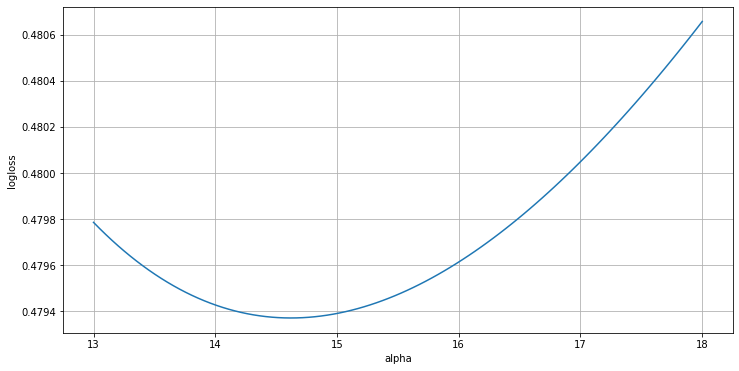

In [203]:
results2 = pd.DataFrame()
# collect alpha list
results2['alpha'] = gridsearch2.cv_results_['param_alpha'].data
# collect test scores
results2['neglogloss'] = gridsearch2.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results2['alpha'], -results2['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [204]:
print("Best parameter: ",gridsearch2.best_params_)

Best parameter:  {'alpha': 14.616161616161616}


In [205]:
print("Best score: ",gridsearch.best_score_) 

Best score:  -0.47939031176439767


In [206]:
clf= MultinomialNB(alpha=15.3)
clf.fit(X_train,y_train)

MultinomialNB(alpha=15.3, class_prior=None, fit_prior=True)

In [0]:
y_predictions = clf.predict(X_test)

In [208]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       845
           1       0.82      0.67      0.74       678

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



In [209]:
cf_matrix = confusion_matrix(y_test,y_predictions)
cf_matrix

array([[745, 100],
       [225, 453]])

In [210]:
accuracy_score(y_test,y_predictions)

0.7866053841103086

Now, let's test our model on our test data! First, we will apply the same cleaning process on the test set, just as we did on the train set


In [212]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
test_df['text'] = test_df['text'].apply(lambda x : remove_URL(x))
test_df['text'] = test_df["text"].apply(lambda x: remove_html(x))
test_df['text'] = test_df["text"].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df["text"].apply(lambda x: remove_punctuation(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [0]:
X_test =  count_vectorizer.transform(list(test_df['text']))
X_test = X_test.toarray()

In [0]:
y_predictions_test = clf.predict(X_test)

In [0]:
output = pd.DataFrame(test_df.id[:3263])
output['target'] = y_predictions_test

In [0]:
output.to_csv('nlp_countvect.csv', index=False)

### 4.2 TFIDF + multinomialNB

Now, let's look into a better approach for text processing, an embedding technique called tf-idf. 

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [0]:
X_tfidf = train_df['text']
y_tfidf = train_df['target']
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=113)

In [0]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf)

In [0]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf)

In [304]:
alpha_list_tfidf =  np.linspace(0.001, 2, 100)
parameter_grid1 = [{"alpha":alpha_list_tfidf}]
clf_mnb = MultinomialNB()
gridsearch1 = GridSearchCV(clf_mnb,parameter_grid1, scoring = 'neg_log_loss', cv = 5)
gridsearch1.fit(X_train_tfidf, y_train_tfidf)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-03, 2.11919192e-02, 4.13838384e-02, 6.15757576e-02,
       8.17676768e-02, 1.01959596e-01, 1.22151515e-01, 1.42343434e-01,
       1.62535354e-01, 1.82727273e-01, 2.02919192e-01, 2.23111111e-01,
       2.43303030e-...
       1.61635354e+00, 1.63654545e+00, 1.65673737e+00, 1.67692929e+00,
       1.69712121e+00, 1.71731313e+00, 1.73750505e+00, 1.75769697e+00,
       1.77788889e+00, 1.79808081e+00, 1.81827273e+00, 1.83846465e+00,
       1.85865657e+00, 1.87884848e+00, 1.89904040e+00, 1.91923232e+00,
       1.93942424e+00, 1.95961616e+00, 1.97980808e+00, 2.00000000e+00])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

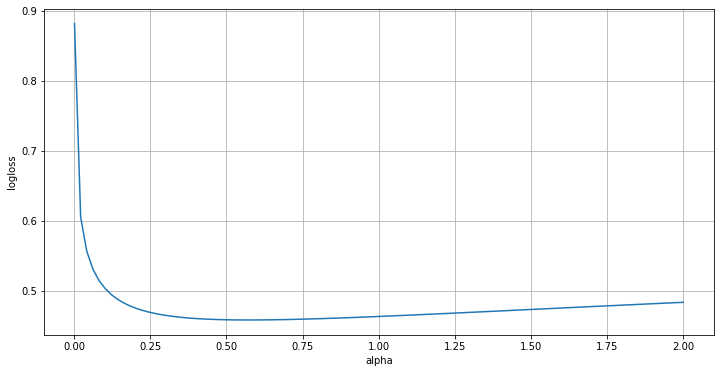

In [305]:
results_tfidf = pd.DataFrame()
# collect alpha list
results_tfidf['alpha'] = gridsearch1.cv_results_['param_alpha'].data
# collect test scores
results_tfidf['neglogloss'] = gridsearch1.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results_tfidf['alpha'], -results_tfidf['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [306]:
alpha_list_tfidf2 =  np.linspace(0.2, 1, 100)
parameter_grid2 = [{"alpha":alpha_list_tfidf2}]
clf_mnb = MultinomialNB()
gridsearch2 = GridSearchCV(clf,parameter_grid2, scoring = 'neg_log_loss', cv = 5)
gridsearch2.fit(X_train_tfidf, y_train_tfidf)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([0.2       , 0.20808081, 0.21616162, 0.22424242, 0.23232323,
       0.24040404, 0.24848485, 0.25656566, 0.26464646, 0.27272727,
       0.28080808, 0.28888889, 0.2969697 , 0.30505051, 0.31313131,
       0.32121212, 0.32929293, 0.33737374, 0....
       0.80606061, 0.81414141, 0.82222222, 0.83030303, 0.83838384,
       0.84646465, 0.85454545, 0.86262626, 0.87070707, 0.87878788,
       0.88686869, 0.89494949, 0.9030303 , 0.91111111, 0.91919192,
       0.92727273, 0.93535354, 0.94343434, 0.95151515, 0.95959596,
       0.96767677, 0.97575758, 0.98383838, 0.99191919, 1.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

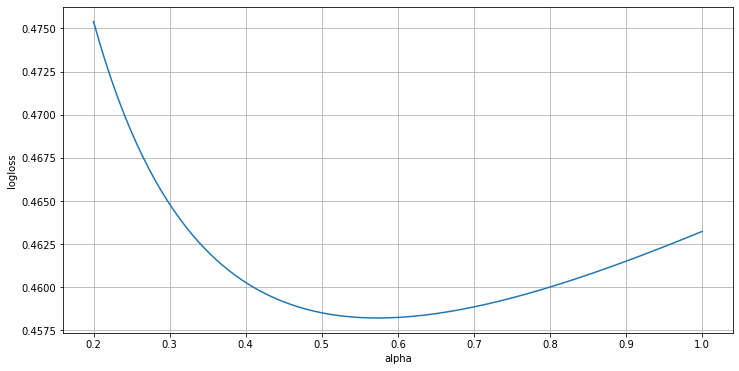

In [307]:
results_tfidf2 = pd.DataFrame()
# collect alpha list
results_tfidf2['alpha'] = gridsearch2.cv_results_['param_alpha'].data
# collect test scores
results_tfidf2['neglogloss'] = gridsearch2.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results_tfidf2['alpha'], -results_tfidf2['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [308]:
print("Best score: ",gridsearch2.best_score_) 

Best score:  -0.45822161382622645


In [309]:
print("Best parameter: ",gridsearch2.best_params_)

Best parameter:  {'alpha': 0.5717171717171717}


In [310]:
clf_mnb = MultinomialNB(alpha=0.57)
clf_mnb.fit(X_train_tfidf,y_train_tfidf)

MultinomialNB(alpha=0.57, class_prior=None, fit_prior=True)

In [311]:
y_predictions_tfidf = clf_mnb.predict(X_test_tfidf)
print(classification_report(y_test_tfidf,y_predictions_tfidf))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       845
           1       0.81      0.68      0.74       678

    accuracy                           0.78      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.78      0.78      1523



In [312]:
cf_matrix_tfidf = confusion_matrix(y_test_tfidf,y_predictions_tfidf)
cf_matrix_tfidf

array([[735, 110],
       [219, 459]])

In [313]:
accuracy_score(y_test_tfidf,y_predictions_tfidf)

0.7839789888378201

Let's test this model on the test dataset.

In [0]:
test_df_tfidf = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [0]:
test_df_tfidf['text'] = test_df_tfidf['text'].apply(lambda x : remove_URL(x))
test_df_tfidf['text'] = test_df_tfidf["text"].apply(lambda x: remove_html(x))
test_df_tfidf['text'] = test_df_tfidf["text"].apply(lambda x: remove_emoji(x))
test_df_tfidf['text'] = test_df_tfidf["text"].apply(lambda x: remove_punctuation(x))
test_df_tfidf['text'] = test_df_tfidf['text'].apply(lambda x : clean_text(x))

In [0]:
X_test_tfidf =  tfidf_vectorizer.transform(list(test_df_tfidf['text']))
X_test_tfidf = X_test_tfidf.toarray()

In [0]:
predictions_tfidf = clf_mnb.predict(X_test_tfidf)

In [0]:
output = pd.DataFrame(test_df_tfidf.id[:3263])
output['target'] = predictions_tfidf

In [0]:
output.to_csv('nlp_tfidf_multinomial.csv', index=False)

### 4.3 Bag of words and logistic regression

Let's try to apply the logistic regression on the count vectorizer.

In [0]:
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',max_df=0.95,min_df=2)
X_cv_lr = count_vectorizer.fit_transform(list(train_df['text']))
X_cv_lr = X_cv_lr.toarray()
y_cv_lr = train_df['target']

In [0]:
X_train_cvlr, X_test_cvlr, y_train_cvlr, y_test_cvlr = train_test_split(X_cv_lr, y_cv_lr, test_size=0.2, random_state=113)

In [274]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_cvlr,y_train_cvlr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_predictions_cvlr = clf_lr.predict(X_test_cvlr)

In [276]:
print(classification_report(y_test_cvlr,predictions_cvlr))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       845
           1       0.80      0.69      0.74       678

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [277]:
cf_matrix_cvlr = confusion_matrix(y_test_cvlr,y_predictions_cvlr)
cf_matrix_cvlr

array([[728, 117],
       [207, 471]])

In [278]:
accuracy_score(y_test_cvlr,y_predictions_cvlr)

0.7872619829284307

Let's test our model on the test dataset.

In [0]:
test_df_cvlr = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [0]:
test_df_cvlr['text'] = test_df_cvlr['text'].apply(lambda x : remove_URL(x))
test_df_cvlr['text'] = test_df_cvlr["text"].apply(lambda x: remove_html(x))
test_df_cvlr['text'] = test_df_cvlr["text"].apply(lambda x: remove_emoji(x))
test_df_cvlr['text'] = test_df_cvlr["text"].apply(lambda x: remove_punctuation(x))
test_df_cvlr['text'] = test_df_cvlr['text'].apply(lambda x : clean_text(x))

In [0]:
X_test_cvlr =  count_vectorizer.transform(list(test_df_cvlr['text']))
X_test_cvlr = X_test_cvlr.toarray()

In [0]:
predictions_cvlr = clf_lr.predict(X_test_cvlr)

In [0]:
output = pd.DataFrame(test_df_cvlr.id[:3263])
output['target'] = predictions_cvlr

In [0]:
output.to_csv('nlp_countvect_logisticregression.csv', index=False)

### 4.4 TFIDF + logisticregression

Now, let's look into a better approach for text processing, an embedding technique called tf-idf and apply logistic regression on it.

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [0]:
X_tfidf_lr = train_df['text']
y_tfidf_lr = train_df['target']
X_train_tfidf_lr, X_test_tfidf_lr, y_train_tfidf_lr, y_test_tfidf_lr = train_test_split(X_tfidf_lr, y_tfidf_lr, test_size=0.2, random_state=113)

In [0]:
X_train_tfidf_lr = tfidf_vectorizer.fit_transform(X_train_tfidf_lr)

In [0]:
X_test_tfidf_lr = tfidf_vectorizer.transform(X_test_tfidf_lr)

In [290]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_tfidf_lr,y_train_tfidf_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [291]:
y_predictions_tfidf_lr = clf_lr.predict(X_test_tfidf_lr)
print(classification_report(y_test_tfidf_lr,y_predictions_tfidf_lr))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       845
           1       0.84      0.68      0.75       678

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [292]:
cf_matrix_tfidf_lr = confusion_matrix(y_test_tfidf_lr,y_predictions_tfidf_lr)
cf_matrix_tfidf_lr

array([[756,  89],
       [217, 461]])

In [293]:
accuracy_score(y_test_tfidf_lr,y_predictions_tfidf_lr)

0.799080761654629

Let's test this model on the test dataset.

In [0]:
test_df_tfidf_lr = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [0]:
test_df_tfidf_lr['text'] = test_df_tfidf_lr['text'].apply(lambda x : remove_URL(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr["text"].apply(lambda x: remove_html(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr["text"].apply(lambda x: remove_emoji(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr["text"].apply(lambda x: remove_punctuation(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr['text'].apply(lambda x : clean_text(x))

In [0]:
X_test_tfidf_lr =  tfidf_vectorizer.transform(list(test_df_tfidf_lr['text']))
X_test_tfidf_lr = X_test_tfidf_lr.toarray()

In [0]:
predictions_tfidf_lr = clf_lr.predict(X_test_tfidf_lr)

In [0]:
output = pd.DataFrame(test_df_tfidf_lr.id[:3263])
output['target'] = predictions_tfidf_lr

In [0]:
output.to_csv('nlp_tfidf_logisticregression.csv', index=False)

## Submission Log


*   21.05 : 4.1 count vectorizer + naive bayes, score = 0.78323
*   21.05 : 4.2 tfidf vectorizer + naive bayes, score = 0.80061
*   21.05 : 4.3 count vectorizer + logistic regression, score = 0.80163
* 21.05 : 4.4 tfidf vectorizer + logistic regression, score = 0.79754




## 4. Transforming tokens to a vector


### **Enter embeddings**

A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.


### **Bags of words**

In [211]:
#def cv(data):
 #   count_vectorizer = CountVectorizer(preprocessor=text_preprocessing)
#
 #   emb = count_vectorizer.fit_transform(data)
#
 #   return emb, count_vectorizer
#
#list_text = train_df["text"].tolist()
#list_labels = train_df["target"].tolist()
#
#X_train, X_test, y_train, y_test = train_test_split(list_text, list_labels, test_size=0.2, 
#                                                                                random_state=40)
#
#X_train_counts, count_vectorizer = cv(X_train)
#X_test_counts = count_vectorizer.transform(X_test)

count_vectorizer = CountVectorizer(preprocessor=text_preprocessing)
train_vectors = count_vectorizer.fit_transform(train_df['text'])
test_vectors = count_vectorizer.transform(test_df["text"])


NameError: ignored


### **Visualizing the embeddings**

Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 20k dimensions is hard, let's project it down to 2.


In [0]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='0')
            green_patch = mpatches.Patch(color='blue', label='1')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.


### **Fitting a classifier**

Starting with a logistic regression is a good idea. It is simple and easy to interpret.


In [0]:
#C=1, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40
clf = LogisticRegression()
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)


### **Evaluation**

Let's start by looking at some metrics to see if our classifier performed well at all.


In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

### **Inspection**

A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [0]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['0','1'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [0]:
sample_submission = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/sample_submission.csv")
y_predicted_countsvect = clf.predict(test_df)
#y_predicted_countsvect = np.round(y_predicted_countsvect).astype(int).reshape(3263)
sample_submission["target"] = y_predicted_countsvect
sample_submission.to_csv("submission_countvect.csv", index=False)


### **TFIDF Bag of Words**

Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(preprocessor=text_preprocessing)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train, X_test, y_train, y_test = train_test_split(list_text, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings look much more separated, let's see if it leads to better performance.

In [0]:
#C=1, class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=111
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [0]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

The results are a little better, let's see if they translate to an actual difference in our use case.

In [0]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['0','1'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("Bag of Words confusion matrix")
print(cm)

### **Naive Bayes classifier for multinomial models**

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [0]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train_counts, y_train)

In [0]:
y_predicted_NB = clf_NB.predict(X_test_counts)

In [0]:
accuracy_NB, precision_NB, recall_NB, f1_NB = get_metrics(y_test, y_predicted_NB)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_NB, precision_NB, recall_NB, f1_NB))

In [0]:
cm3 = confusion_matrix(y_test, y_predicted_NB)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm3, classes=['0','1'], normalize=False, title='Confusion matrix')
plt.show()

naive bays multinomial on tfidf

In [0]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train_tfidf, y_train)

In [0]:
y_predicted_NB_tfidf = clf_NB.predict(X_test_tfidf)

In [0]:
accuracy_NB_tfidf, precision_NB_tfidf, recall_NB_tfidf, f1_NB_tfidf = get_metrics(y_test, y_predicted_NB_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_NB_tfidf, precision_NB_tfidf, recall_NB_tfidf, f1_NB_tfidf))

### **KNN Classifier**

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [0]:
clf_knn = knn.fit(X_train_counts, y_train)

In [0]:
y_predicted_knn = clf_knn.predict(X_test_counts)

In [0]:
accuracy_knn_count, precision_knn_count, recall_knn_count, f1_knn_count = get_metrics(y_test, y_predicted_knn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_knn_count, precision_knn_count, recall_knn_count, f1_knn_count))

In [0]:
clf_knn_tfidf = knn.fit(X_train_tfidf, y_train)

In [0]:
y_predicted_knn_tfidf = clf_knn_tfidf.predict(X_test_tfidf)

In [0]:
accuracy_knn_count, precision_knn_count, recall_knn_count, f1_knn_count = get_metrics(y_test, y_predicted_knn_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_knn_count, precision_knn_count, recall_knn_count, f1_knn_count))